In [24]:
import numpy as np
import pandas as pd
from datetime import datetime
import urllib3
import urllib.request
import lib
import zipfile
import zipfile2
from zipfile import ZipFile
import time
from urllib.request import urlretrieve, Request, FancyURLopener
import os
import os.path
import requests
import statsmodels.api as sm
import matplotlib.pyplot as plt

### Assignment 12.1: STEP : 1

#### Downloading data via calling the API

In [17]:
headers = {"User-Agent": "Safari/15.1"}

downloadPath = os.getcwd()

for year in range(1995, 2020) :
    quarters = ('QTR1', 'QTR2', 'QTR3', 'QTR4')
    # Download and extract each file
    for quarter in quarters:
        req_url = 'https://www.sec.gov/Archives/edgar/full-index/' + str(year) + '/'+str(quarter)+ '/master' + '.zip'
        request = Request(url, headers=headers) 
        response = urllib.request.urlopen(request)
        
        with open(downloadPath+'\\sec_fillings' + str(year) + '_' + str(quarter) + '.zip', "wb") as fo:
            fo.write(response.read())        
        
        
        with zipfile2.ZipFile(downloadPath+'\\sec_fillings' + str(year) + '_' + str(quarter) + '.zip', 'r') as zip:
            zip.extractall(downloadPath+'\\sec_fillings' + str(year) + '_' + str(quarter))

#### Cleaning and taking random 50 lines as asked

In [21]:
final_data = np.empty((0, 5), str)

for year in range(1995, 2020):
    quarters = ('QTR1', 'QTR2', 'QTR3', 'QTR4')
    for quarter in quarters:
        with open(downloadPath+'\\sec_fillings' + str(year) + '_' + str(quarter) + '/master.idx', encoding='latin-1') as op:
            for i in range(11):
                op.readline()
            placeholder_list = []
            # Reading each line
            for line in op:
                    line = line[0:-1]
                    splits = list(line.split('|'))
                    
                    if (splits[2] == '8-K'):
                        placeholder_list.append(splits)
                        
            final_records = np.array(placeholder_list)
            indices = np.random.randint(np.size(final_records, 0), size = 50)
            final_data = np.append(final_data, final_records[indices, :], axis = 0)

#### Store into CSV File

In [23]:
sec_fillings = pd.DataFrame(final_data, columns = ['CIK', 'CompanyName', 'FormTypes', 'DATE', 'link'])
sec_fillings.to_csv(downloadPath+'\\sec_fillings.csv')

### Assignment 12.1: STEP : 2 : Event Studies

#### Reading SEC, DAILY DATA and COMPUSTAT data for event studies

In [25]:
comp_data = pd.read_csv('Q:\\Data-ReadOnly\\COMP\\funda.csv', header = 0)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (8,10,12,16,26,30,920,946,947) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [27]:
FUNDA = comp_data.copy()
FUNDA['cusip'] = FUNDA['cusip'].str[0:6]
FUNDA = FUNDA[['fyear', 'cusip', 'cik']]
FUNDA.head()

,fyear,cusip,cik
0,1961.0,000032,NaN
1,1962.0,000032,NaN
2,1963.0,000032,NaN
3,1964.0,000032,NaN
4,1965.0,000032,NaN


In [30]:
SEC_FILLINGS = pd.read_csv(downloadPath+'\\sec_fillings.csv', header = 0)
SEC_FILLINGS = SEC_FILLINGS.iloc[:, 1:5]
SEC_FILLINGS['filingdate'] = pd.to_datetime(SEC_FILLINGS['DATE'], format='%Y/%m/%d')
SEC_FILLINGS['YEAR'] = pd.DatetimeIndex(SEC_FILLINGS['DATE']).year
SEC_FILLINGS[["CIK"]] = SEC_FILLINGS[["CIK"]].apply(pd.to_numeric, errors = 'coerce')
SEC_FILLINGS.head()

,CIK,CompanyName,FormTypes,DATE,filingdate,YEAR
0,1298675,CubeSmart,8-K,2019-10-11,2019-10-11,2019
1,1493137,"Lifeloc Technologies, Inc",8-K,2019-11-12,2019-11-12,2019
2,1557883,"Dermira, Inc.",8-K,2019-11-13,2019-11-13,2019
3,1587523,Knowles Corp,8-K,2019-10-24,2019-10-24,2019
4,876378,"TRANSENTERIX, INC.",8-K,2019-11-13,2019-11-13,2019


In [33]:
FUNDA = FUNDA.rename(columns={'fyear': 'YEAR', 'cusip': 'CUSIP', 'cik' : 'CIK'})
FUNDA_SEC = pd.merge(FUNDA, SEC_FILLINGS, how = 'inner', on = ['YEAR', 'CIK'])
FUNDA_SEC = FUNDA_SEC[['CUSIP', 'YEAR', 'CIK', 'CompanyName', 'FormTypes', 'filingdate']]
FUNDA_SEC = FUNDA_SEC.drop_duplicates()

In [38]:
dsf_new = pd.read_csv("Q:\\Data-ReadOnly\\CRSP\\dsf_new.csv")
DSF = dsf_new.copy()
DSF = DSF[['CUSIP','DATE', 'PRC', 'SHROUT', 'RET', 'VWRETD', 'VOL']]
DSF['CUSIP'] = DSF['CUSIP'].str[0:6]
cols = DSF.columns.drop(['CUSIP', 'DATE'])
DSF[cols] = DSF[cols].apply(pd.to_numeric, errors='coerce')
DSF['DATE'] = DSF['DATE'].apply(str)
DSF['DATE'] = pd.to_datetime(DSF['DATE'])
DSF['YEAR'] = pd.DatetimeIndex(DSF['DATE']).year
DSF['PREV_YEAR'] = DSF['YEAR'] - 1
DSF.head()

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (2,7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,CUSIP,DATE,PRC,SHROUT,RET,VWRETD,VOL,YEAR,PREV_YEAR
0,683916,1986-01-06,NaN,NaN,NaN,-0.000138,NaN,1986,1985
1,683916,1986-01-07,-2.5625,3680.0,NaN,0.013809,1000.0,1986,1985
2,683916,1986-01-08,-2.5000,3680.0,-0.02439,-0.020744,12800.0,1986,1985
3,683916,1986-01-09,-2.5000,3680.0,0.00000,-0.011219,1400.0,1986,1985
4,683916,1986-01-10,-2.5000,3680.0,0.00000,0.000083,8500.0,1986,1985


#### Merge All datasets

In [41]:
FUNDA_SEC['YEAR'] = FUNDA_SEC['YEAR'].astype(int)
DSF['YEAR'] = DSF['YEAR'].astype(int)
master_dataset = pd.merge(DSF, FUNDA_SEC, how = 'inner', left_on = ['CUSIP', 'YEAR'], right_on = ['CUSIP', 'YEAR'])
master_dataset.head()

,CUSIP,DATE,PRC,SHROUT,RET,VWRETD,VOL,YEAR,PREV_YEAR,CIK,CompanyName,FormTypes,filingdate
0,NaN,2019-01-02,141.0,18774.0,-0.024829,0.001791,112825.0,2019,2018,353184.0,AIR T INC,8-K,2019-12-19
1,NaN,2019-01-02,141.0,18774.0,-0.024829,0.001791,112825.0,2019,2018,353184.0,AIR T INC,8-K,2019-11-14
2,NaN,2019-01-02,141.0,18774.0,-0.024829,0.001791,112825.0,2019,2018,5981.0,AMERICAN VANGUARD CORP,8-K,2019-11-06
3,NaN,2019-01-02,141.0,18774.0,-0.024829,0.001791,112825.0,2019,2018,1037868.0,AMETEK INC/,8-K,2019-10-31
4,NaN,2019-01-02,141.0,18774.0,-0.024829,0.001791,112825.0,2019,2018,318154.0,AMGEN INC,8-K,2019-10-29


Saving master dataset - to use in 12.2

In [42]:
master_dataset.to_csv(downloadPath+"\\master_dataset.csv")

#### Cleaning master dataset

In [45]:
ALL_DATA = master_dataset
CHECK = [(ALL_DATA['DATE'] == ALL_DATA['filingdate']), (ALL_DATA['DATE'] != ALL_DATA['filingdate'])]
ALL_DATA['filing_checker'] = np.select(CHECK, [1,0])
ALL_DATA["RET"] = ALL_DATA["RET"].apply(pd.to_numeric, errors = 'coerce')
ALL_DATA.dropna()
ALL_DATA['turnover'] = ALL_DATA['VOL']/ALL_DATA['SHROUT']
ALL_DATA['adjust'] = (np.log(ALL_DATA['turnover'] + (2.55 * (10 ** (-6)))))
ALL_DATA['regression'] = (ALL_DATA.groupby('CUSIP')['adjust'].shift(-11).rolling(60, min_periods = 1).sum())/60
ALL_DATA['val'] = np.power((ALL_DATA['adjust'] - ALL_DATA['regression']), 2)
ALL_DATA['std'] = ALL_DATA.groupby('CUSIP')['val'].shift(-11).rolling(60, min_periods = 1).sum()
ALL_DATA['adj_std'] = np.sqrt(ALL_DATA['std']/60)
ALL_DATA['ATO'] = ((ALL_DATA['adjust'] - ALL_DATA['regression'])/(ALL_DATA['adj_std']))

ALL_DATA.head()

,CUSIP,DATE,PRC,SHROUT,RET,VWRETD,VOL,YEAR,PREV_YEAR,CIK,...,FormTypes,filingdate,filing_checker,turnover,adjust,regression,val,std,adj_std,ATO
0,NaN,2019-01-02,141.0,18774.0,-0.024829,0.001791,112825.0,2019,2018,353184.0,...,8-K,2019-12-19,0,6.009641,1.793365,NaN,NaN,NaN,NaN,NaN
1,NaN,2019-01-02,141.0,18774.0,-0.024829,0.001791,112825.0,2019,2018,353184.0,...,8-K,2019-11-14,0,6.009641,1.793365,NaN,NaN,NaN,NaN,NaN
2,NaN,2019-01-02,141.0,18774.0,-0.024829,0.001791,112825.0,2019,2018,5981.0,...,8-K,2019-11-06,0,6.009641,1.793365,NaN,NaN,NaN,NaN,NaN
3,NaN,2019-01-02,141.0,18774.0,-0.024829,0.001791,112825.0,2019,2018,1037868.0,...,8-K,2019-10-31,0,6.009641,1.793365,NaN,NaN,NaN,NaN,NaN
4,NaN,2019-01-02,141.0,18774.0,-0.024829,0.001791,112825.0,2019,2018,318154.0,...,8-K,2019-10-29,0,6.009641,1.793365,NaN,NaN,NaN,NaN,NaN


In [57]:
def myfunc(df, a,  b):
    return sm.OLS(df[b], df[a]).fit().predict()

capm = ALL_DATA.groupby('CUSIP').apply(myfunc, 'VWRETD', 'RET')
capm_c = capm.copy()
capm_c = pd.DataFrame(capm_c)
final_list = capm_c.iloc[:, 0:1]
final_list = final_list.reset_index()
final_list = final_list.iloc[:, 0:1]
final_list = final_list.set_axis(['CUSIP'], axis = 1,inplace = False)
total_cusips = final_list['CUSIP'].count()

#### Calculating Alpha and Beta Values

In [58]:
coe_array = np.array(capm)
coe_list = coe_array.tolist()
index_list = list(capm.index)
coe_val = pd.DataFrame(np.concatenate(coe_list))

                
alpha = coe_val.iloc[0:total_cusips, 0:1]
alpha['CUSIP'] = index_list
alpha = alpha.rename(columns={alpha.columns[0]: 'ALPHA'})

beta = coe_val.iloc[total_cusips:2*total_cusips, 0:1]
beta['CUSIP'] = index_list
beta = beta.rename(columns={beta.columns[0]: 'BETA'})

alpha_beta = pd.merge(alpha, beta, how = 'inner', on = ['CUSIP'])
ALL_DATA_betas = pd.merge(ALL_DATA, alpha_beta, how = 'inner', on = 'CUSIP')

ALL_DATA_betas = ALL_DATA_betas.dropna()
ALL_DATA_betas['AR'] = ALL_DATA_betas['RET'] - (ALL_DATA_betas['ALPHA'] + ALL_DATA_betas['BETA'] * ALL_DATA_betas['VWRETD'])
ALL_DATA_betas['CAR0'] = ALL_DATA_betas['AR']
ALL_DATA_betas['CAR1'] = ALL_DATA_betas.groupby(['CUSIP'])['AR'].shift(1).rolling(3, min_periods = 1).sum().shift(-1)
ALL_DATA_betas['CAR2'] = ALL_DATA_betas.groupby(['CUSIP'])['AR'].shift(2).rolling(5, min_periods = 1).sum().shift(-2)
ALL_DATA_betas['CAR3'] = ALL_DATA_betas.groupby(['CUSIP'])['AR'].shift(3).rolling(7, min_periods = 1).sum().shift(-3)
ALL_DATA_betas['CAR5'] = ALL_DATA_betas.groupby(['CUSIP'])['AR'].shift(5).rolling(11, min_periods = 1).sum().shift(-5)

selected_data = ALL_DATA_betas.loc[ALL_DATA_betas['filing_checker'] == 1]
CAR = selected_data[['CIK'] + ['ATO'] + ['CAR0'] + ['CAR1'] + ['CAR2'] + ['CAR3'] + ['CAR5']]
CAR_DESC = CAR[['ATO'] + ['CAR0'] + ['CAR1'] + ['CAR2'] + ['CAR3'] + ['CAR5']]
CAR_DESC.describe()

,ATO,CAR0,CAR1,CAR2,CAR3,CAR5
count,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000,2691.000000
mean,0.578485,0.002964,0.005650,0.007103,0.004617,0.001829
std,1.228396,0.122061,0.241546,0.274950,0.296104,0.333667
min,-3.282840,-0.805788,-1.761484,-1.894813,-2.028142,-2.253025
25%,-0.278597,-0.017414,-0.039778,-0.056914,-0.072573,-0.104512
50%,0.442220,-0.000554,-0.001187,-0.000896,-0.002066,-0.005401
75%,1.317576,0.017114,0.035686,0.051873,0.067376,0.089468
max,4.970387,4.432156,8.883267,8.889782,8.917258,8.905870


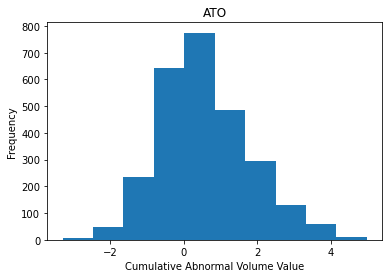

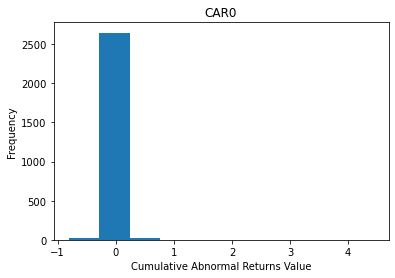

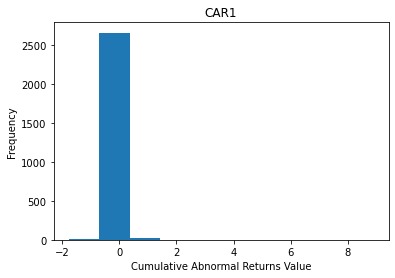

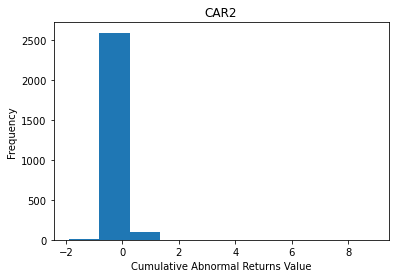

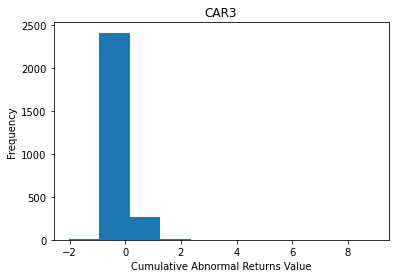

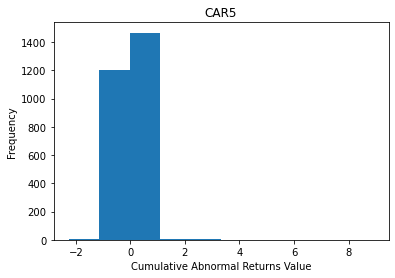

In [59]:
ATOplot = CAR['ATO'].plot.hist()
plt.xlabel('Cumulative Abnormal Volume Value')
plt.title('ATO')
plt.show()

CAR0plot = CAR['CAR0'].plot.hist()
plt.xlabel('Cumulative Abnormal Returns Value')
plt.title('CAR0')
plt.show()

CAR1plot = CAR['CAR1'].plot.hist()
plt.xlabel('Cumulative Abnormal Returns Value')
plt.title('CAR1')
plt.show()

CAR2plot = CAR['CAR2'].plot.hist()
plt.xlabel('Cumulative Abnormal Returns Value')
plt.title('CAR2')
plt.show()

CAR3plot = CAR['CAR3'].plot.hist()
plt.xlabel('Cumulative Abnormal Returns Value')
plt.title('CAR3')
plt.show()

CAR5plot = CAR['CAR5'].plot.hist()
plt.xlabel('Cumulative Abnormal Returns Value')
plt.title('CAR5')
plt.show()

In [62]:
CAR.to_csv(downloadPath+"\\CAR.csv")